In [ ]:
from PIL import Image
import os
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
import zipfile

zip_path = "/content/archive (3).zip"  # Change to your ZIP file path
extract_path = "dataset"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping done!")


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])
train_data = ImageFolder(root="/content/dataset/train-20250112T065955Z-001/train", transform=transform)
test_data = ImageFolder(root="/content/dataset/test-20250112T065939Z-001/test", transform=transform)
train = DataLoader(train_data, batch_size=32, shuffle=True)
test = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
class FakeRealClassifier(nn.Module):
    def __init__(self):
        super(FakeRealClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = FakeRealClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train:
        images, labels = images.to(device), labels.float().to(device)
        labels = labels.view(-1, 1)  # Reshape labels for BCELoss

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
st = model.state_dict()
torch.save(st, 'AI_2.tar')
print("Training complete!")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 0.6771
Epoch [2/10], Loss: 0.6313
Epoch [3/10], Loss: 0.5001
Epoch [4/10], Loss: 0.4955
Epoch [5/10], Loss: 0.4587
Epoch [6/10], Loss: 0.5843
Epoch [7/10], Loss: 0.5057
Epoch [8/10], Loss: 0.5095
Epoch [9/10], Loss: 0.2961
Epoch [10/10], Loss: 0.4425
Training complete!


Fake


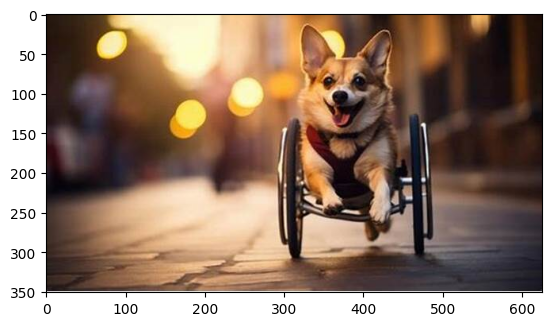

In [ ]:
st = torch.load('AI_2.tar', weights_only=False)
model.load_state_dict(st)

img = Image.open(os.path.join("/content/Fake.jpg")).convert('RGB')
img_t = transform(img).unsqueeze(0)

model.eval()
predict = model(img_t)
p = torch.argmax(predict, dim=1)
print("Fake") if p == 0 else print("Real")
plt.imshow(img)
plt.show()